Today I am going to do a little exploratory analysis of the <a href="https://github.com/thegetty/provenance-index-csv/tree/master/knoedler">Getty Research Institute's Knoedler Stock Books dataset</a>, which contains over 40,000 sales records from the stockbooks of art dealer M. Knoedler & Co dating from 1872–1970. I'm not familiar with the dataset, so I'm going to start by answering a simple question that will give us a sense of the scope of the data: Based on when Knoedler acquired and sold artworks, when was Knoedler most active?

First, let's do our standard imports:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Next, let's load our dataset and get a sense for its size:

In [2]:
knoedler = pd.read_csv('../data/knoedler.csv')

knoedler.shape

/Users/zrottman/miniconda3/envs/test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (5,6,7,36,42,43,44,47,50,51,52,54,55,56,68,71,72,73,75,76,77,80,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(40250, 89)

So, we are dealing here with a sizeable dataset consisting, as advertised, of 40,250 salesbook records, each with 89 columns or variables. Based on this warning message, it looks like we'll have to clean up the dataset a little and make sure that our datatypes are accurate. We'll get to that later.

Before we start to answer our question about Knoedler's period of activity, let's figure out what a few sample rows of data look like:

In [3]:
knoedler_sample = knoedler.sample(3)

pd.options.display.max_rows = 90 # We want all 89 variables here, unabbreviated 

knoedler_sample.T

,10009,26473,17730
pi_record_no,K-10012,K-26481,K-17735
stock_book_no,4,8,2
knoedler_number,6333,A739,NaN
page_number,117,84,206
row_number,35,54,24
consign_no,NaN,NaN,NaN
consign_name,NaN,NaN,NaN
consign_loc,NaN,NaN,NaN
artist_name_1,Jacquet,Lepine,Goyard da Passi
art_authority_1,"JACQUET, GUSTAVE JEAN","LÉPINE, JOSEPH","GUARDABASSI, GUERRINO"


Now we have a rough picture of the kind of information a given entry may have (or may not have). As we can see, we should be prepared for quite a bit of missing information. This doesn't surprise me, since we're dealing with messy, real-world data transcribed from hand-written stockbooks maintained by multiple individuals over the course of nearly a century: some information may be elided or obscured, whereas other variables will not be applicable in every case (for example, seconds artists or second buyers).

Let's return to the task at hand: When was Knoedler was most active? In particular, we are interested in sorting out when artworks entered Knoedler's stockbooks (for now, the year will suffice: <code>entry_date_yea</code>) and when they exited (<code>sale_date_year</code>). Because there's evidently much data missing, it would be helpful to get a sense for how representative the data from these two fields are of the entire dataset:

In [4]:
entry_count = knoedler.entry_date_year.notnull().sum() # Count the non-null entries for entry_date_year
sale_count = knoedler.sale_date_year.notnull().sum() # Count the non-null entries for sale_date_year
total_count = len(knoedler) # Count the number of entries in the full dataset

print("entry_date_year size: {0} entries ({1:.2f}% of database entries)".
      format(entry_count, entry_count/total_count*100))
print("sale_date_year size: {0} entries ({1:.2f}% of database entries)".
      format(sale_count, sale_count/total_count*100))

entry_date_year size: 38264 entries (95.07% of database entries)
sale_date_year size: 27569 entries (68.49% of database entries)


As we can see above, ~95% of the entries in the original dataset have a non-null <code>entry_date_year</code> associated with them, whereas only ~68% of the original dataset has a <code>sale_date_year</code>. Does the lower number of sale dates point to the fact that a significant proportion of artworks remained unsold? Perhaps—this is a hypothesis to explore later. For now, this observation simply helps contextualize the graphical representations of the dealer's activity that we're about to perform.

Now it's time to draw up a histogram to visualize the dealer's periods of activity. What I'd like is a stacked histogram that shows us total transactional activity (the sum of its acquisitions and its sales) while also clearly differentiating these two variables. Seaborn's histogram function provides a convenient way of doing this, but it will require consolidating and simplifying our data so that we can represent the year of the transaction along the x-axis and the transaction type (i.e., acquisition or sale) by color. We're aiming for a DataFrame, in other words, with two columns—<code>transaction_year</code> and <code>transaction_type</code>—indexed by the unique identifier <code>pi_record_no</code>.

I'll start by creating a new DataFrame with only the non-null <code>entry_date_year</code> values:

In [5]:
entry_date_year = knoedler.dropna(subset=['entry_date_year'])[['pi_record_no', 'entry_date_year']]
entry_date_year

,pi_record_no,entry_date_year
0,K-1,1906.0
1,K-2,1876.0
2,K-3,1876.0
3,K-4,1876.0
4,K-5,1876.0
...,...,...
40245,K-40442,1875.0
40246,K-23858,1875.0
40247,K-23859,1875.0
40248,K-40336,1902.0


Next, let's rename add a new column specifying transaction type and then renamning the existing <code>entry_date_year</code> column to refer to the generic transaction year:

In [6]:
entry_date_year['transaction_type'] = 'entry'
entry_date_year.rename(columns={'entry_date_year':'transaction_year'}, inplace=True)
entry_date_year

,pi_record_no,transaction_year,transaction_type
0,K-1,1906.0,entry
1,K-2,1876.0,entry
2,K-3,1876.0,entry
3,K-4,1876.0,entry
4,K-5,1876.0,entry
...,...,...,...
40245,K-40442,1875.0,entry
40246,K-23858,1875.0,entry
40247,K-23859,1875.0,entry
40248,K-40336,1902.0,entry


Now let's do the same thing for our sales data:

In [7]:
sale_date_year = knoedler.dropna(subset=['sale_date_year'])[['pi_record_no', 'sale_date_year']]
sale_date_year.rename(columns={'sale_date_year':'transaction_year'}, inplace=True)
sale_date_year['transaction_type'] = 'sale'
sale_date_year

,pi_record_no,transaction_year,transaction_type
0,K-1,1907.0,sale
1,K-2,1878.0,sale
2,K-3,1878.0,sale
3,K-4,1877.0,sale
4,K-5,1877.0,sale
...,...,...,...
40245,K-40442,1875.0,sale
40246,K-23858,1875.0,sale
40247,K-23859,1875.0,sale
40248,K-40336,1905.0,sale


Time to concatenate! (Incidentally, now that we've expunged all those pesky <code>NaN</code> values, we can also recast the transaction year data to integers, so I'll do that, too.)

In [8]:
activity = pd.concat([entry_date_year, sale_date_year], ignore_index=True)
activity['transaction_year'] = activity['transaction_year'].astype(int)
activity

,pi_record_no,transaction_year,transaction_type
0,K-1,1906,entry
1,K-2,1876,entry
2,K-3,1876,entry
3,K-4,1876,entry
4,K-5,1876,entry
...,...,...,...
65828,K-40442,1875,sale
65829,K-23858,1875,sale
65830,K-23859,1875,sale
65831,K-40336,1905,sale


Just to see what we've got, let's reindex this new DataFrame hierarchically according to the unique <code>pi_record_no</code> and then <code>transaction_type</code>:

In [9]:
activity.set_index(['pi_record_no', 'transaction_type']).sort_index().head(20)

transaction_year
pi_record_no transaction_type                  
K-1          entry                         1906
             sale                          1907
K-10         entry                         1876
             sale                          1879
K-100        entry                         1876
             sale                          1879
K-1000       entry                         1878
K-10000      entry                         1889
             sale                          1889
K-10001      entry                         1889
             sale                          1889
K-10002      entry                         1889
K-10003      entry                         1889
             sale                          1890
K-10004      entry                         1889
K-10005      entry                         1889
             sale                          1890
K-10006      entry                         1889
K-10007      entry                         1889
             sale                          1890

This new multi-indexed DataFrame allows us to easily see that some objects were acquired and then resold, while others only have an entry date (perhaps they were not resold) or only a sale date (missing data?). Note that because the <code>pi_record_no</code> field is a string, the data is sorted alphabetically and not as we might expect.

In any event, with our new DataFrame we're ready to take advantage of seaborn's histogram function, since we can simply plot the transaction year data along the x-axis and color-code according to the transaction type category:

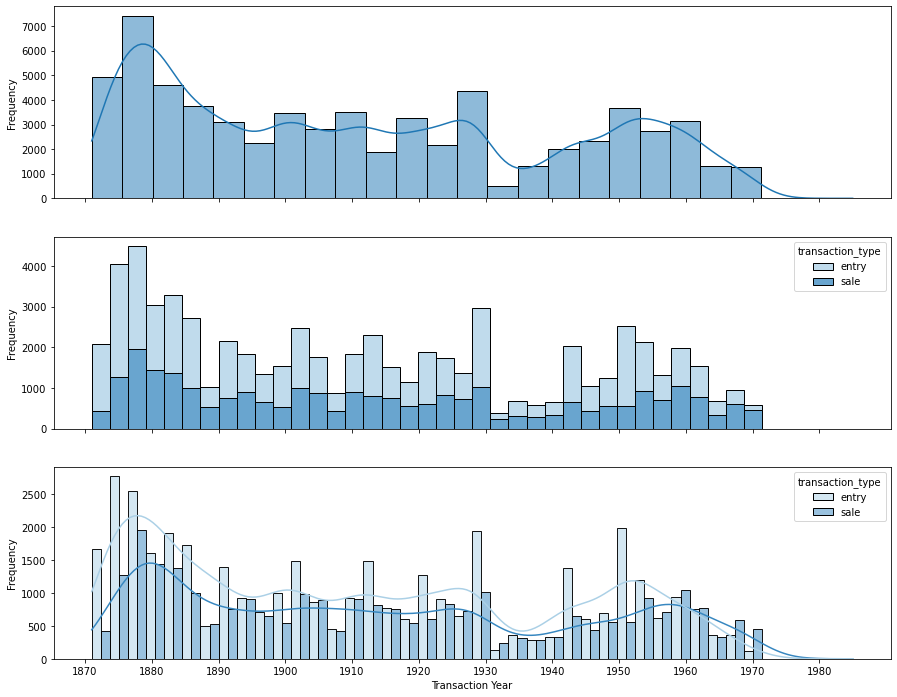

In [10]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 12))

# Histogram 1
sns.histplot(
    activity, 
    x='transaction_year', 
    palette='Blues',
    kde=True,
    ax=axs[0], bins=25
)

# Histogram 2
sns.histplot(
    activity, 
    x='transaction_year', 
    multiple='stack', 
    hue='transaction_type', 
    palette='Blues',
    ax=axs[1]
)

# Histogram 3
sns.histplot(
    activity, 
    x='transaction_year', 
    multiple='dodge',
    hue='transaction_type', 
    palette='Blues',
    kde=True,
    ax=axs[2]
)

# Set ticks and axis labels
for ax in axs:
    ax.set_xticks(range(1870, 1990, 10))
    ax.set_xlabel("Transaction Year")
    ax.set_ylabel("Frequency");

There we have it! I've drawn up three histograms that emphasize different aspects of the data:
<ul>
    <li>The first histogram visualizes the sum of all transactional activity (acquisitions + sales) with a kernel density estimate line to smooth out the distribution.</li>
    <li>In the second chart I've differentiated between acquisitions (light blue) and sales (dark blue) to get a sense of how the transactional activity breaks down.</li>
    <li>The final histogram, lastly, includes acquisitions and sales data side-by-side so that we can get a better sens of how the two types of activities compare. I've also included density estimates here to smooth out the overall patterns of activity.</li>
</ul>

Looking at the above, however, it occurs to me that a histogram is not the ideal chart, since each bin represents multiple years' worth of transactional activity. Transactions span from 1871 to 1985, and I've opted for the default 40 bins, which means each bar represents the total transactions for about 2.85 years. Not very helpful if we're trying to get a sense of the dealer's annual activity! How about simply counting up the transactions per year and charting that as a line graph? Let's try that instead.

In [49]:
# Pivot the data and count up the transactions per year of each type
activity_count = activity.pivot_table(
    values='transaction_year',
    index='transaction_year', 
    columns='transaction_type', 
    aggfunc='count'
)

# Add columns for moving averages to smooth out the data
activity_count['entry_ma10'] = activity_count.entry.rolling(10).mean()
activity_count['sale_ma10'] = activity_count.sale.rolling(10).mean()

activity_count

transaction_type,entry,sale,entry_ma10,sale_ma10
transaction_year,,,,
1871,8.0,NaN,NaN,NaN
1872,376.0,NaN,NaN,NaN
1873,1280.0,423.0,NaN,NaN
1874,808.0,360.0,NaN,NaN
1875,1136.0,536.0,NaN,NaN
...,...,...,...,...
1968,138.0,201.0,215.9,241.0
1969,65.0,265.0,193.7,229.2
1970,55.0,150.0,159.7,212.3


This is looking promising. Now, for each year, we have the number of acquisitions (<code>entry</code>) and sales (<code>sale</code>), as well as ten-year moving averages for each of these activity types (<code>entry_ma10</code> and <code>sale_ma10</code>). Let's chart it.

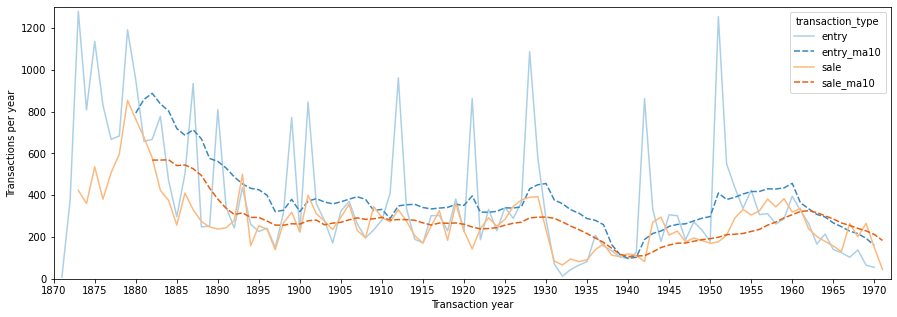

In [64]:
# Configure figure labels and axes
plt.figure(figsize=(15,5))
plt.xlabel('Transaction year')
plt.ylabel('Transactions per year')
plt.ylim((0, 1300))
plt.xlim((1870, 1972))
plt.xticks(np.arange(1870, 1972, 5))

# Chart acquisitions: per year and 10-year moving average (excluding the outlying 1985 transaction)
sns.lineplot(data=activity_count[['entry', 'entry_ma10']][:-1], palette='Blues')

# Chart sales: per year and 10-year moving average (excluding the outlying 1985 transaction)
sns.lineplot(data=activity_count[['sale', 'sale_ma10']][:-1], palette='Oranges');

Now we're getting somewhere! Along with the trio of histograms above, this line chart gives us a sense for trends in Knoedler's activity, measured in this case by the number of transactions per year: We can observe a peak in activity early on in the 1870s; on average, activity settles to a consistent level by the turn of the century; there is an abrupt drop in activity during the Depression before a slow recovery to pre-Depression levels; and in general acqusition activity is much less consistant than sale activity, seemingly occurring in spurts every five or ten years. We can also clearly see that, on average, acquisitions outpaced sales, until around the 1960s, which is perhaps when the business began to unwind its inventory.

This is only part of the story, of course. For the art historian, this information helps us find deeper questions to ask. What was happening historically—in general and specifically in the context of the art market—that might explain Knoedler's patterns of activity and inactivity? What explains the sporadic bursts in buying activity? How do these larger patterns of transactional activity break down according to geographical markets or invididual artist markets? In my next excursion into this dataset, I'll see if we can gain some additional insights into measuring and specifying the dealer's patterns of activity.